In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datalab_utils
import astropy.units as u
import os

from dl import authClient as ac, queryClient as qc
from collections import Counter
from tqdm import tqdm
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
base_dir = "/dlusers/adriansh/work/analyses/"
fig_dir = os.path.join(base_dir, "plots/strings/7july2024/")
results_dir = os.path.join(base_dir, "results/strings/7july2024/")

In [48]:
SECONDS_PER_DAY = 86400
FILTER_ORDER = {f: i for i, f in enumerate(['u', 'g', 'r', 'i', 'z', 'Y', "VR"])}

def _filter_map(char):
    return FILTER_ORDER[char]

filter_map = np.vectorize(_filter_map)

def count_samples(df):
    n_samples = len(df)
    n_baseline = df["cluster_label"].sum()
    n_bright = n_samples - n_baseline
    data = {"n_baseline": [n_baseline], "n_bright": [n_bright]}
    result = pd.DataFrame(data=data, index=[df.iloc[0, 0]])
    return result

def is_multichromatic(s):
    vals = Counter(s).values()
    result = (len(vals) > 1) and ((np.array(list(vals)) > 1).all())
    return result

def biggest_diff(chars):
    x = np.array([FILTER_ORDER[k] for k in list(set(chars))])
    result = x.max() - x.min()
    return result

def finite_average_delta_t(s):

    if np.isfinite(s["t_start_max"]):
        ts_max = s["t_start_max"]
    else:
        ts_max = s["t_start_min"]

    if np.isfinite(s["t_end_max"]):
        te_max = s["t_end_max"]
    else:
        te_max = s["t_end_min"]

    ts_min = s["t_start_min"]
    te_min = s["t_end_min"]
    result = ((te_max - ts_max) + (te_min - ts_min)) / 2
    return result

def t_of_tau(tau, ts):
    """valid for ts[2] - ts[1] <= tau <=ts[3] - ts[0]]"""
    t0, t1, t2, t3 = ts
    result = (t1 - t0 - (t1 + tau - t3) * np.heaviside(t1 + tau - t3, 0) - 
              (t2 - tau - t0) * np.heaviside(t2 - tau - t0, 0))
    return result

def compute_taus(ts):
    t0, t1, t2, t3 = ts
    tau0 = t2 - t1
    tau3 = t3 - t0
    t_max = min([t1 - t0, t3 - t2])
    tau1 = tau0 + t_max
    tau2 = tau3 - t_max
    result = (tau0, tau1, tau2, tau3)
    return result

def event_duration_posterior(ts, tau_bins):
    result = np.zeros(tau_bins.shape)
    # move this check outside of this function.
    if np.isfinite(ts).all():
        tau0, tau1, tau2, tau3 = compute_taus(ts)
        special_bins_right = np.digitize([tau0, tau1, tau2, tau3], bins=tau_bins)
        special_bins_left = special_bins_right - 1
        tau1_edges = tau_bins[special_bins_right[0]: special_bins_right[1]]
        tau2_edges = tau_bins[special_bins_right[1]: special_bins_right[2]]
        tau3_edges = tau_bins[special_bins_right[2]: special_bins_right[3]]
        integration_edges = np.concatenate([[tau0], tau1_edges, [tau1], tau2_edges, [tau2], tau3_edges, [tau3]])
        integral_bins = np.concatenate([[special_bins_left[0]], np.arange(special_bins_right[0], special_bins_right[1]), 
                                        [special_bins_left[1]], np.arange(special_bins_right[1], special_bins_right[2]),
                                        [special_bins_left[2]], np.arange(special_bins_right[2], special_bins_right[3])])
        t_taus = t_of_tau(integration_edges)
        integral_vals = ((integration_edges[1:] - integration_edges[:-1]) * 
                         (t_taus[1:] + t_taus[:-1]) / 2)
        np.add.at(result, integral_bins, integral_vals)
    else:
        result[-1] += 1

    result /= result.sum()
    return result

def _compute_t_start(mjds, exp_times, start_idx, end_idxs, taus):
    n_taus = taus.size
    # Start at the end of start_idx exposure
    result = np.array([mjds[start_idx] + exp_times[start_idx]] * n_taus)
    # Shift if the last bright sample integrates past the end of the window
    t_start_shift = np.maximum((mjds[t_end_idxs] + exp_times[t_end_idxs]) - taus, 0)
    result += t_start_shift
    return result

def _delta_t_ends(mjds, t_end_idxs, t_starts, taus):
    return mjds.take(t_end_idxs + 1, mode="clip") - (t_starts + taus)

def _good_window(n_filters_bright, n_filters_baseline):
    bright_filter_mask = n_filters_bright > 1
    baseline_filter_mask = n_filters_baseline > 1
    enough_filters = bright_filter_mask.sum(axis=1) > 1
    bright_and_baseline = (~bright_filter_mask | baseline_filter_mask).all(axis=1)
    result = enough_filters & bright_and_baseline
    return result

def _keep_scanning(lc_continues, delta_t_ends, delta_t_starts):
    return lc_continues & (delta_t_ends < delta_t_starts)

def compute_total_time(lc, taus):
    n_filters = len(FILTER_ORDER.keys())
    n_taus = len(taus)
    tau_idx = np.arange(n_taus)
    mjds = lc["mjd"].values
    filters = lc["filter"].values
    exp_times = lc["exptime"].values / SECONDS_PER_DAY
    n_samples = len(mjds)
    n_filters_all = np.zeros(n_filters)
    n_filters_bright = np.zeros((n_taus, n_filters))
    mjd_idxs = np.arange(n_samples)
    initial_t_start = mjds[0] + exp_times[0]
    t_end_idxs = np.array([mjd_idxs[mjds < initial_t_start + taus[i]][-1] for i in tau_idx]) #Vectorize?
    t_starts = _compute_t_start(mjds, exp_times, 0, t_end_idxs, taus)
    result = np.zeros(n_taus)

    #Can probably Vectorize this
    for i in tau_idx:
        n_filters_bright[i][filter_map(filters[1: t_end_idxs[i] + 1])] += 1

    n_filters_baseline = n_filters_all - n_filters_bright

    for i in range(n_samples - 2):
        lc_continues = t_end_idxs != n_samples - 1
        # What if shifting puts t_start into the next exposure? Done
        delta_t_starts = np.maximum(mjds[i+1] - t_starts, 0)
        # Using numpy take as a safe getter. delta_t_ends will be negative 
        # for taus where lc_continues is False, but &ing with lc_continues will 
        # Take care of that.
        # What if the window ends in the exposure of the last bright sample?
        delta_t_ends = _delta_t_ends(mjds, t_end_idxs, t_starts, taus)
        keep_scanning = _keep_scanning(lc_continues, delta_t_ends, delta_t_starts)

        while keep_scanning.any():
            # I think I can inadvertently end up with negative delta_t_starts
            # here on subsequent iterations due to the slim chance that shifting
            # a window by the exposure time of the sample succeeding the window
            # could shift t_start into the integration window of the first window of the sample.
            # For example, if there's 1s between the end of the window and the succeeding sample
            # and 2s between the start of the window and the first bright sample
            # the window shifts 1s, then the succeeding sample has a 5s exposure time, shifting
            # the window 5s right. The First bright sample has a 10s exposure time, and now 
            # t_start is 4s into the integration time of the first bright sample.
            # This would result in a negative delta_t_start though, and delta_t_end
            # will be positive so keep_scanning for that tau will be false
            # and then the next iteration of the for loop will shift the window back into place
            good_window = _good_window(n_filters_bright, n_filters_baseline) & keep_scanning

            if good_window.any():
                result[good_window] += delta_t_ends[good_window]

            t_end_idxs[keep_scanning] += 1
            next_filter = filters.take(t_end_idxs, mode="clip")
            next_filter_idx = filter_map(next_filter)
            n_filters_bright[tau_idx[keep_scanning], next_filter_idx[keep_scanning]] += 1
            n_filters_baseline[tau_idx[keep_scanning], next_filter_idx[keep_scanning]] -= 1
            t_start[keep_scanning] = _compute_t_start(mjds, exp_times, i, t_end_idxs, taus)[keep_scanning]
            delta_t_starts = mjds[i+1] - t_starts
            delta_t_ends = _delta_t_ends(mjds, t_end_idxs, t_starts, taus)
            lc_continues = t_end_idxs != n_samples - 1
            keep_scanning = _keep_scanning(lc_continues, delta_t_ends, delta_t_starts)

        bright_filter_mask = n_filters_bright > 1
        baseline_filter_mask = n_filters_baseline > 1
        good_window = _good_window(n_filters_bright, n_filters_baseline)
        result[good_window] += delta_t_starts[good_window]
        next_filter_idx = filter_map(filters[i+1])
        n_filters_bright[:,  next_filter_idx] -= 1
        n_filters_baseline[:,  next_filter_idx] += 1
        t_starts = _compute_t_start(mjds, exp_times, 0, t_end_idxs, taus)

    return result

In [139]:
def d_map(char):
    d = {'a': 0, 'b': 1}
    return d[char]
d_map_vec = np.vectorize(d_map)
d_map_vec(['a', 'a', 'b'])
d_map_vec('a')

array(0)

In [148]:
a = np.arange(100).reshape((10, 10))
a[:, [1]] += 1
a

array([[ 0,  2,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 12, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 22, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 32, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 42, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 52, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 62, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 72, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 82, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 92, 92, 93, 94, 95, 96, 97, 98, 99]])

In [9]:
lc_df_all = pd.read_parquet(f"{results_dir}lightcurves.parquet")
time_df_all = pd.read_parquet(f"{results_dir}aggregates.parquet")

In [10]:
lc_df_all.sort_values(by=["objectid", "mjd"], inplace=True)

In [11]:
g = lc_df_all.groupby(by="objectid", sort=False)

In [31]:
group = list(g.groups.keys())[1]

In [41]:
lc = g.get_group(group)
lc = lc.sort_values(by="mjd")

In [46]:
mjds = lc["mjd"].values
exp_times = lc["exptime"].values * (u.s.to(u.day))
filters = lc["filter"].values
taus = np.geomspace(1e-4, 1e4, num=50)

In [53]:
%timeit time_lensable(mjds, exp_times, filters, taus)
%timeit datalab_utils.measure_time(lc, taus)
%timeit datalab_utils.cluster_label_dataframe(lc)

35.7 ms ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.7 µs ± 166 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
3.93 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
len(lc)

61

In [95]:
a = np.tile(np.arange(200), 10).reshape((10, 200))
test_array = np.arange(0, 100, 10)
b = a > test_array.reshape((10, 1))
%timeit idxs = [[i, a[i][b[i]][0]] for i in range(a.shape[0])]

8.01 µs ± 13.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [65]:
%%timeit
for element in a:
    if element > 80:
        value = element
        break

4.96 µs ± 8.57 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
# Roll this stuff up in some functions
# lc_df_achromatic = lc_df_all.groupby(by="objectid", sort=False).filter(lambda group: datalab_utils.lens_filter(group, achromatic=True, factor_of_two=False))
# lc_df_achromatic_factor = lc_df_achromatic.groupby(by="objectid", sort=False).filter(lambda group: datalab_utils.lens_filter(group, achromatic=True, factor_of_two=True))

results_df_all = datalab_utils.make_lensing_dataframe(lc_df_all)
results_df_achromatic = datalab_utils.make_lensing_dataframe(lc_df_achromatic)
results_df_achromatic_factor = datalab_utils.make_lensing_dataframe(lc_df_achromatic_factor)

filter_diffs_all = results_df_all["filters"].apply(biggest_diff)
filter_diffs_achromatic = results_df_achromatic["filters"].apply(biggest_diff)
filter_diffs_achromatic_factor = results_df_achromatic_factor["filters"].apply(biggest_diff)

n_samples_all = lc_df_all.groupby("objectid", group_keys=False).apply(count_samples)
n_samples_all.index.name = "objectid"
n_samples_achromatic = lc_df_achromatic.groupby("objectid", group_keys=False).apply(count_samples)
n_samples_achromatic.index.name = "objectid"
n_samples_achromatic_factor = lc_df_achromatic_factor.groupby("objectid", group_keys=False).apply(count_samples)
n_samples_achromatic_factor.index.name = "objectid"

results_df_all = results_df_all.assign(achromatic=results_df_all["filters"].apply(lambda x: len(set(x)) > 1),
                                       delta_t_max=lambda x: x["t_end_max"] - x["t_start_max"],
                                       delta_t_min=lambda x: x["t_end_min"] - x["t_start_min"],
                                       multiplicity_2=results_df_all["filters"].apply(is_multichromatic),
                                       n_bright=results_df_all["filters"].apply(lambda x: len(x)))
results_df_achromatic = results_df_achromatic.assign(achromatic=results_df_achromatic["filters"].apply(lambda x: len(set(x)) > 1),
                                                     delta_t_max=lambda x: x["t_end_max"] - x["t_start_max"],
                                                     delta_t_min=lambda x: x["t_end_min"] - x["t_start_min"],
                                                     multiplicity_2=results_df_achromatic["filters"].apply(is_multichromatic),
                                                     n_bright=results_df_achromatic["filters"].apply(lambda x: len(x)))
results_df_achromatic_factor = results_df_achromatic_factor.assign(achromatic=results_df_achromatic_factor["filters"].apply(lambda x: len(set(x)) > 1),
                                                                   delta_t_max=lambda x: x["t_end_max"] - x["t_start_max"],
                                                                   delta_t_min=lambda x: x["t_end_min"] - x["t_start_min"],
                                                                   multiplicity_2=results_df_achromatic_factor["filters"].apply(is_multichromatic),
                                                                   n_bright=results_df_achromatic_factor["filters"].apply(lambda x: len(x)))

In [27]:
results_df_all["delta_t_av"] = (results_df_all["delta_t_max"] + results_df_all["delta_t_min"]) / 2
results_df_achromatic["delta_t_av"] = (results_df_achromatic["delta_t_max"] + results_df_achromatic["delta_t_min"]) / 2
results_df_achromatic_factor["delta_t_av"] = (results_df_achromatic_factor["delta_t_max"] + 
                                              results_df_achromatic_factor["delta_t_min"]) / 2

In [28]:
n_events_all = results_df_all.groupby(level=0).filters.agg("count")
n_events_achromatic = results_df_achromatic.groupby(level=0).filters.agg("count")
n_events_achromatic_factor = results_df_achromatic_factor.groupby(level=0).filters.agg("count")

n_events_all.name = "n_events"
n_events_achromatic.name = "n_events"
n_events_achromatic_factor.name = "n_events"

lc_df_all.sort_values(by=["objectid", "mjd"], inplace=True)
lc_df_achromatic.sort_values(by=["objectid", "mjd"], inplace=True)
lc_df_achromatic_factor.sort_values(by=["objectid", "mjd"], inplace=True)

results_df_all.sort_index(level=0, inplace=True)
results_df_achromatic.sort_index(level=0, inplace=True)
results_df_achromatic_factor.sort_index(level=0, inplace=True)

n_events_all.sort_index(inplace=True)
n_events_achromatic.sort_index(inplace=True)
n_events_achromatic_factor.sort_index(inplace=True)

In [13]:
taus = np.geomspace(1e-4, 1e4, num=50)

cadence_results_all = {f"{n}": np.zeros((2, taus.size)) for n in n_events_all.value_counts().index}
n_samples_x_all = np.arange(0, n_events_all.max()+1)
n_samples_y_all = np.zeros(n_samples_x_all.shape)
n_bright_y_all = np.zeros(n_samples_x_all.shape)
g_lc = lc_df_all.groupby(by="objectid", sort=False)
g_res = results_df_all.groupby(level=0, sort=False)

for (name1, lc), (name2, res), idx in zip(g_lc, g_res, n_events_all.index):
    assert name1 == name2 == idx
    nev = n_events_all.loc[idx]
    cadence_results_all[f"{nev}"][0] += datalab_utils.measure_time(lc, taus)
    n_samples_y_all[nev] += len(lc)
    n_bright_y_all[nev] += res["n_bright"].sum()
    h, _ = np.histogram(res["delta_t_av"], bins=taus)
    n_infinite = sum(~np.isfinite(res["delta_t_av"]))
    cadence_results_all[f"{nev}"][1, :-1] += h
    cadence_results_all[f"{nev}"][1, -1] += n_infinite

In [14]:
cadence_results_achromatic = {f"{n}": np.zeros((2, taus.size)) for n in n_events_achromatic.value_counts().index}
n_samples_x_achromatic = np.arange(0, n_events_achromatic.max()+1)
n_samples_y_achromatic = np.zeros(n_samples_x_achromatic.shape)
n_bright_y_achromatic = np.zeros(n_samples_x_achromatic.shape)
g_lc = lc_df_achromatic.groupby(by="objectid", sort=False)
g_res = results_df_achromatic.groupby(level=0, sort=False)

for (name1, lc), (name2, res), idx in zip(g_lc, g_res, n_events_achromatic.index):
    assert name1 == name2 == idx
    nev = n_events_achromatic.loc[idx]
    cadence_results_achromatic[f"{nev}"][0] += datalab_utils.measure_time(lc, taus)
    n_samples_y_achromatic[nev] += len(lc)
    n_bright_y_achromatic[nev] += res["n_bright"].sum()
    h, _ = np.histogram(res["delta_t_av"], bins=taus)
    n_infinite = sum(~np.isfinite(res["delta_t_av"]))
    cadence_results_achromatic[f"{nev}"][1, :-1] += h
    cadence_results_achromatic[f"{nev}"][1, -1] += n_infinite

In [15]:
cadence_results_achromatic_factor = {f"{n}": np.zeros((2, taus.size)) for n in n_events_achromatic_factor.value_counts().index}
n_samples_x_achromatic_factor = np.arange(0, n_events_achromatic_factor.max()+1)
n_samples_y_achromatic_factor = np.zeros(n_samples_x_achromatic_factor.shape)
n_bright_y_achromatic_factor = np.zeros(n_samples_x_achromatic_factor.shape)
g_lc = lc_df_achromatic_factor.groupby(by="objectid", sort=False)
g_res = results_df_achromatic_factor.groupby(level=0, sort=False)

for (name1, lc), (name2, res), idx in zip(g_lc, g_res, n_events_achromatic_factor.index):
    assert name1 == name2 == idx
    nev = n_events_achromatic_factor.loc[idx]
    t = datalab_utils.measure_time(lc, taus)
    cadence_results_achromatic_factor[f"{nev}"][0] += t
    n_samples_y_achromatic_factor[nev] += len(lc)
    n_bright_y_achromatic_factor[nev] += res["n_bright"].sum()
    h, _ = np.histogram(res["delta_t_av"], bins=taus)
    n_infinite = sum(~np.isfinite(res["delta_t_av"]))
    cadence_results_achromatic_factor[f"{nev}"][1, :-1] += h
    cadence_results_achromatic_factor[f"{nev}"][1, -1] += n_infinite

In [29]:
filters_in_event_all = results_df_all["filters"].apply(lambda x: "".join(sorted(set(x))))
filters_in_event_achromatic = results_df_achromatic["filters"].apply(lambda x: "".join(sorted(set(x))))
filters_in_event_achromatic_factor = results_df_achromatic_factor["filters"].apply(lambda x: "".join(sorted(set(x))))

filters_in_event_hist_all = filters_in_event_all.value_counts()
filters_in_event_hist_achromatic = filters_in_event_achromatic.value_counts()
filters_in_event_hist_achromatic_factor = filters_in_event_achromatic_factor.value_counts()

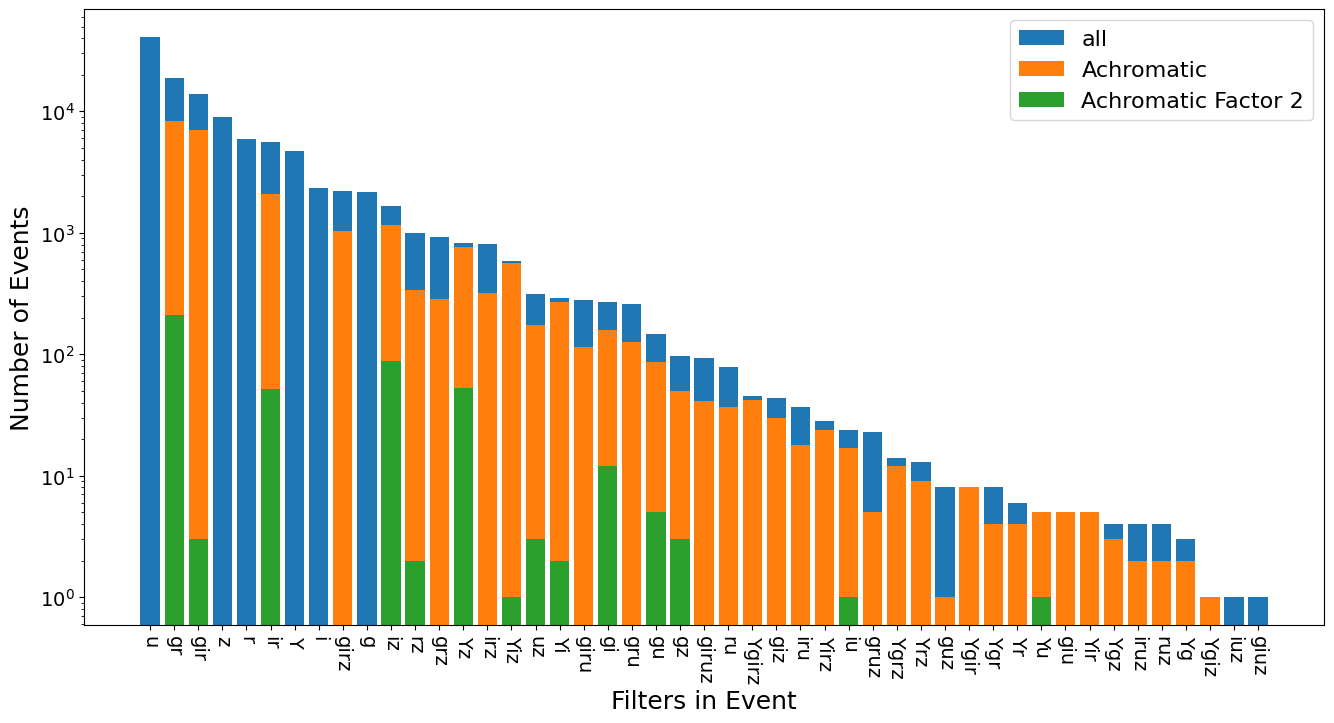

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(filters_in_event_hist_all.index, filters_in_event_hist_all, label="all")
ax.bar(filters_in_event_hist_achromatic.index, filters_in_event_hist_achromatic, label="Achromatic")
ax.bar(filters_in_event_hist_achromatic_factor.index, filters_in_event_hist_achromatic_factor, label="Achromatic Factor 2")
ax.set_yscale("log")
ax.set_xlabel("Filters in Event", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-90)
ax.legend(loc="upper right", fontsize=16)
# fig.savefig(f"{fig_dir}filters_in_event.png")
plt.show(fig)

In [31]:
n_events_per_source_all = results_df_all.groupby(level=0).t_start_max.agg("count")
n_events_per_source_achromatic = results_df_achromatic.groupby(level=0).t_start_max.agg("count")
n_events_per_source_achromatic_factor = results_df_achromatic_factor.groupby(level=0).t_start_max.agg("count")

In [32]:
n_events_freq_all = n_events_per_source_all.value_counts()
n_events_freq_achromatic = n_events_per_source_achromatic.value_counts()
n_events_freq_achromatic_factor = n_events_per_source_achromatic_factor.value_counts()

n_events_freq_all.index.name = "n_events"
n_events_freq_achromatic.index.name = "n_events"
n_events_freq_achromatic_factor.index.name = "n_events"

In [33]:
n_events_freq_all.name = "all"
n_events_freq_achromatic.name = "achromatic"
n_events_freq_achromatic_factor.name = "achromatic_factor2"
temp = pd.Series(np.zeros(n_events_freq_all.index.max() + 1), name="temp")

n_events_freq_df = pd.concat([n_events_freq_all, n_events_freq_achromatic, 
                              n_events_freq_achromatic_factor, temp], axis=1)
n_events_freq_df.index.name = "n_events"
n_events_freq_df.replace(np.nan, 0, inplace=True)
n_events_freq_df.sort_index(inplace=True)
n_events_freq_df.drop(columns="temp", inplace=True)

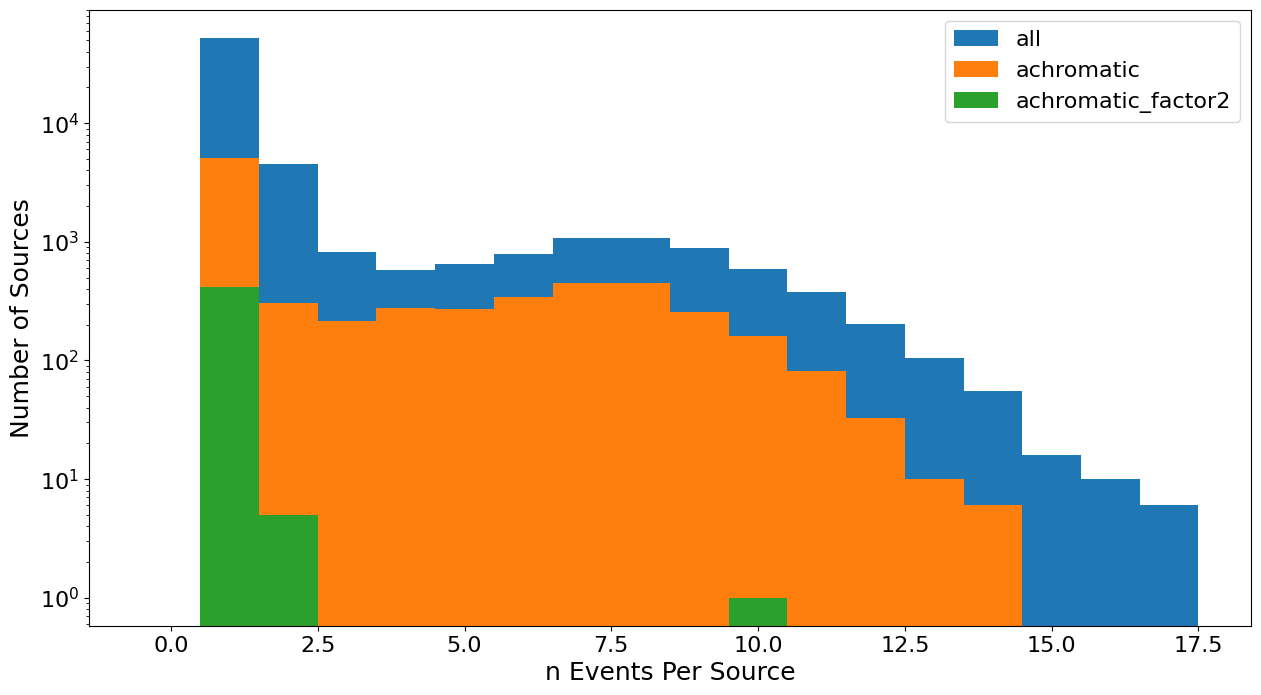

In [34]:
n_events_freq_df.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
# x_ticks = np.arange(0, 10 * np.ceil(n_events_freq_df.index.max() / 10) + 10, 10).astype(int)

for col in n_events_freq_df.columns:
    x = n_events_freq_df[col].index.values
    y = n_events_freq_df[col].values
    ax.bar(x, y, width=1, label=col)

# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_ticks, rotation=-90)
# ax.set_xlim((x_ticks.min(), x_ticks.max()))
ax.legend(loc="upper right", fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n Events Per Source", fontsize=18)
ax.set_ylabel("Number of Sources", fontsize=18)
ax.tick_params(labelsize=16)
# fig.savefig(f"{fig_dir}events_per_source_hist.png")
plt.show(fig)

In [70]:
taus = np.geomspace(1e-4, 1e4, num=50)
hist_counts = np.zeros((3, taus.shape[0]))
dfs = [results_df_all, results_df_achromatic, results_df_achromatic_factor]

for j in range(len(dfs)):
    df = dfs[j]
    t_matrix = df[["t_start_max", "t_start_min", "t_end_min", "t_end_max"]].values
    
    
    for i in range(t_matrix.shape[0]):
        ts = t_matrix[i]
        post = event_duration_posterior(ts, taus)
        hist_counts[j] += post

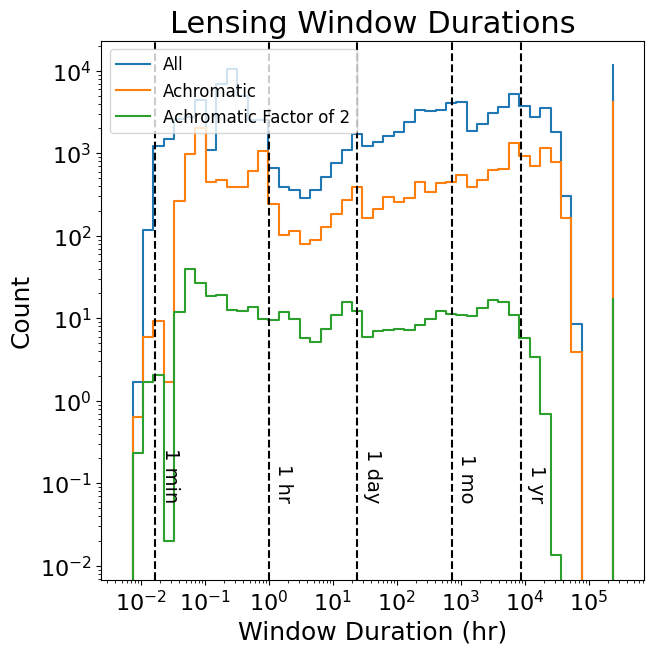

In [72]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.hr).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
x = taus * 24
labels = ["All", "Achromatic", "Achromatic Factor of 2"]

fig, ax = plt.subplots(figsize=(7, 7))

for i in range(len(labels)):
    h = hist_counts[i]
    label = labels[i]
    ax.plot(x, h, ds="steps-post", label=label)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((x[0], 3*x[-1]))
ax.legend(loc="upper left", fontsize=12)
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.15)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
fig.savefig(f"{fig_dir}lensing_window_durations.png")
plt.close(fig)

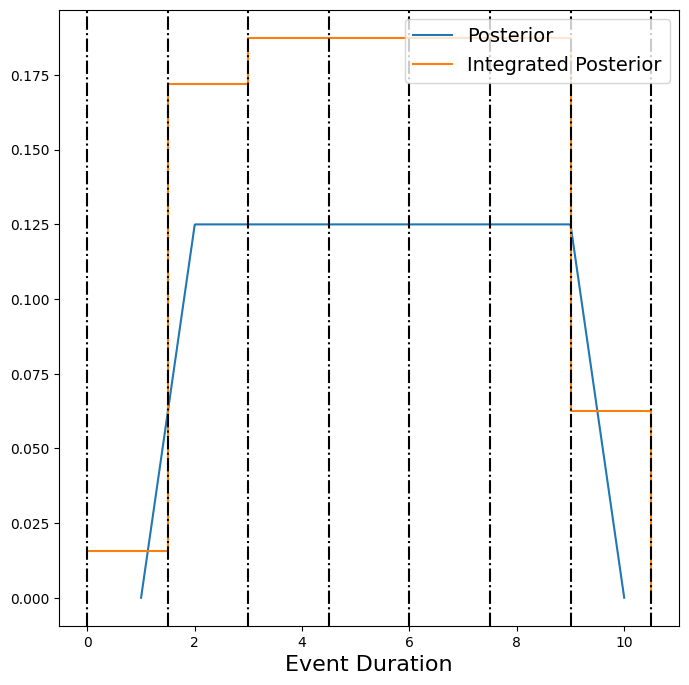

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))
bins = np.arange(0, 12, 1.5)
ts = (0, 1, 2, 10)
t0, t1, t2, t3 = ts
x = np.linspace(t2 - t1, t3 - t0, num=1001)
lam = 1/20
ax.plot(x, t_of_tau(x, ts)/(t_of_tau(x, ts).sum()*(x[1]-x[0])), label="Posterior")
post = event_duration_posterior(ts, bins)
ax.plot(bins, post, ds="steps-post", label="Integrated Posterior")

for b in bins:
    ax.axvline(x=b, color='k', ls="-.")

ax.legend(loc="upper right", fontsize=14)
ax.set_xlabel("Event Duration", fontsize=16)
plt.show(fig)

In [159]:
0.9 * (t_of_tau(2, ts) + t_of_tau(1.1, ts)) / 2 + 0.2 * (t_of_tau(2, ts) + t_of_tau(2.2, ts)) / 2

0.675

In [122]:
bins = np.arange(0, 11, 1.1)

In [123]:
tau_min = t2 - t1
tau_max = t3 - t0
t_max = min([t1 - t0, t3 - t2])
tau1 = tau_min + t_max
tau2 = tau_max - t_max
special_bins = np.digitize([tau_min, tau1, tau2, tau_max], bins=bins) - 1
all_bins = np.arange(special_bins[0], special_bins[-1] + 1)
regular_bins = all_bins[~np.isin(all_bins, special_bins)]

In [124]:
all_bins, regular_bins, special_bins

(array([0, 1, 2]), array([], dtype=int64), array([0, 1, 1, 2]))

In [125]:
integration = np.zeros((len(bins),))

In [126]:
tau1_edges = bins[special_bins[0]+1: special_bins[1]+1]
tau2_edges = bins[special_bins[1]+1: special_bins[2]+1]
tau_max_edges = bins[special_bins[2]+1: special_bins[3]+1]

In [127]:
tau1_edges, tau2_edges, tau_max_edges

(array([1.1]), array([], dtype=float64), array([2.2]))

In [129]:
integration_edges = np.concatenate([[tau_min], tau1_edges, [tau1], tau2_edges, [tau2], tau_max_edges, [tau_max]])
integration_edges

array([1. , 1.1, 2. , 2. , 2.2, 3. ])

In [130]:
integral_bins = np.digitize(integration_edges, bins=bins) - 1

In [132]:
vals = ((integration_edges[1:] - integration_edges[:-1]) * 
        (t_of_tau(integration_edges[1:], ts) + 
         t_of_tau(integration_edges[:-1], ts)) / 2)
integration = np.zeros((len(bins),))

for i in range(len(integral_bins) - 1):
    b = integral_bins[i]
    v = vals[i]
    integration[b] += v

In [141]:
integral_bins, vals, integration, bins

(array([0, 1, 1, 1, 2, 2]),
 array([0.005, 0.495, 0.   , 0.18 , 0.32 ]),
 array([0.005, 0.675, 0.32 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0. , 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9]))

[10  6 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [ 420.5         684.         -344.          -17.00342649  -24.12143055
  -33.99986667  -47.46366868  -65.28744108  -87.73288417 -113.41243968
 -136.6802127  -141.86259138  -90.78717075   65.90840785  239.20049223
  344.07792133  494.9388475   711.9447299  1024.09681719 1473.11195229
   83.53488071]


array([ -17.00342649,  -24.12143055,  -33.99986667,  -47.46366868,
        -65.28744108,  -87.73288417,  570.58756032, -136.6802127 ,
       -141.86259138,  -90.78717075,  486.40840785,  239.20049223,
        344.07792133,  494.9388475 ,  711.9447299 , 1024.09681719,
       1473.11195229,   83.53488071,    0.        , -344.        ])

In [21]:
n_samples_lc_all = lc_df_all.groupby(by="objectid", sort=False).mag_auto.agg("count")

NameError: name 'lc_df_all' is not defined

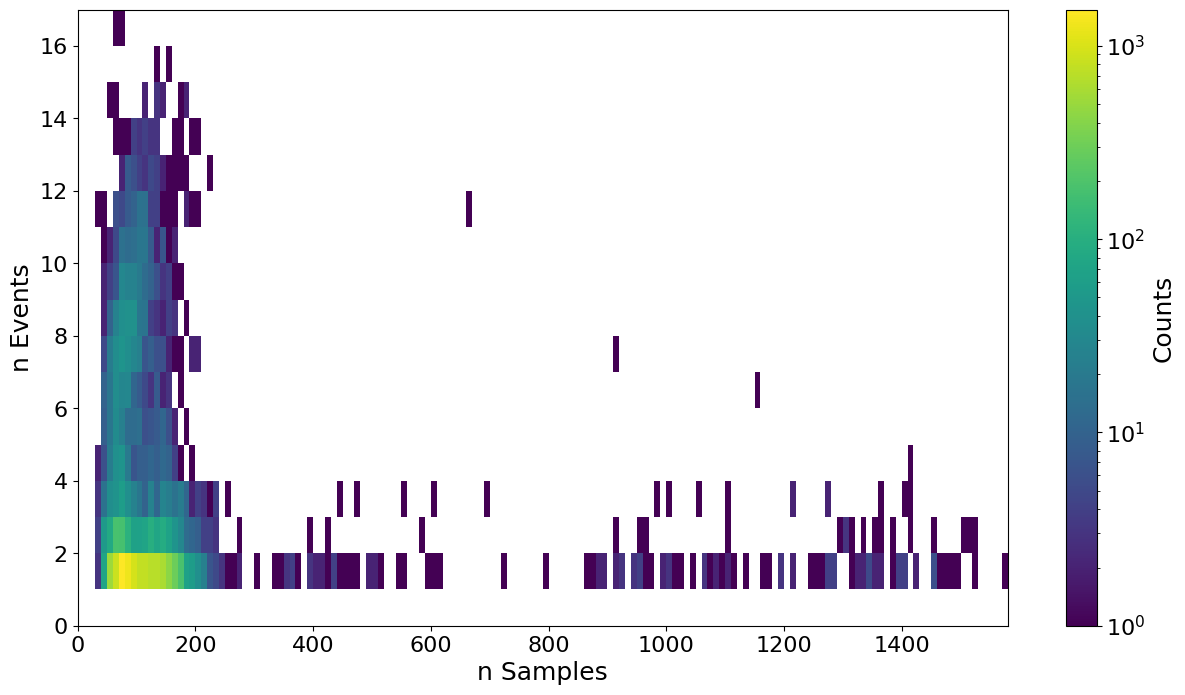

In [23]:
fig, ax = plt.subplots(figsize=(15, 8))
# ax.scatter(n_samples_lc, n_events, alpha=0.25, s=4)
hist = ax.hist2d(n_samples_lc_all, n_events_all, 
                 bins=[np.arange(0, n_samples_lc_all.max()+10, 10), 
                       np.arange(0, n_events_all.max()+1)], 
                 norm=LogNorm())

colorbar = plt.colorbar(hist[3], ax=ax)
colorbar.set_label('Counts', fontsize=18)
colorbar.ax.tick_params(labelsize=16)

# ax.legend(loc="upper right", fontsize=16)
ax.set_xlabel("n Samples", fontsize=18)
ax.set_ylabel("n Events", fontsize=18)
ax.tick_params(labelsize=16)
m = n_events_all.iloc[0] / n_samples_lc_all.iloc[0]
# ax.set_xlim((0, 250))
# ax.set_ylim((0, 100))
# ax.set_xlim((0, 100))
# fig.savefig(f"{fig_dir}n_events_n_samples.png")
plt.show(fig)

In [24]:
n_samples_lc_achromatic_factor = lc_df_achromatic_factor.groupby(by="objectid", sort=False).mag_auto.agg("count")

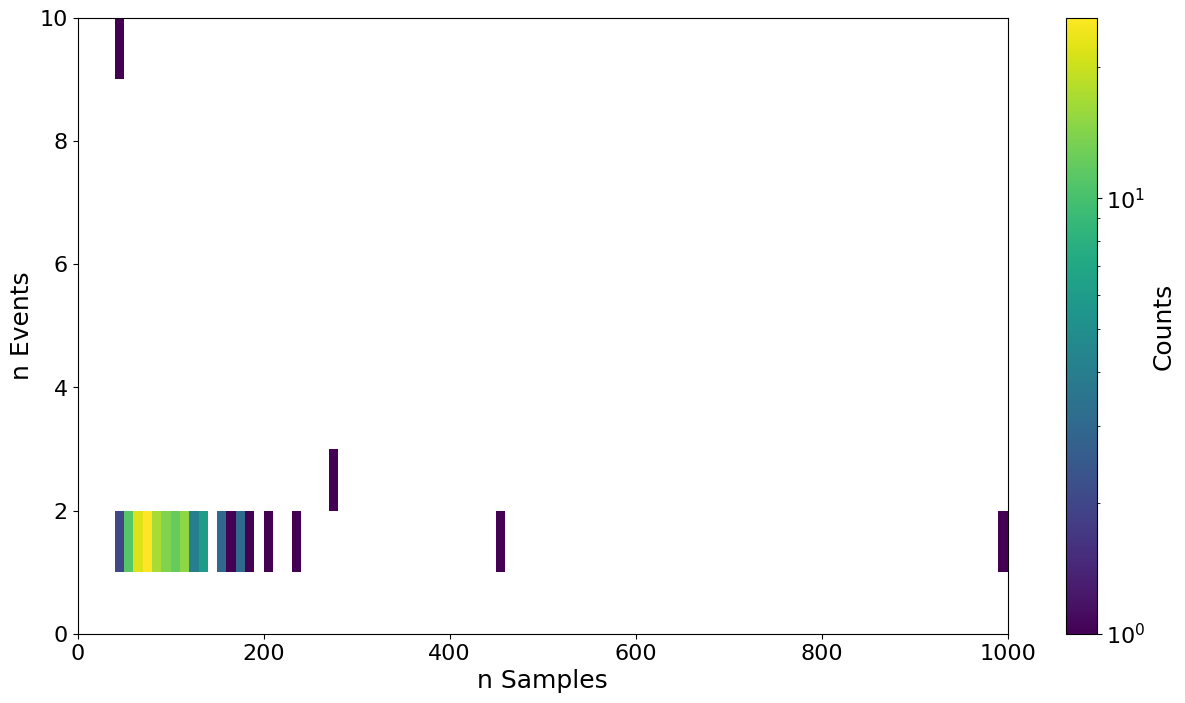

In [25]:
fig, ax = plt.subplots(figsize=(15, 8))
# ax.scatter(n_samples_lc, n_events, alpha=0.25, s=4)
hist = ax.hist2d(n_samples_lc_achromatic_factor, n_events_achromatic_factor, 
                 bins=[np.arange(0, n_samples_lc_achromatic_factor.max()+10, 10), 
                       np.arange(0, n_events_achromatic_factor.max()+1)], 
                 norm=LogNorm())

colorbar = plt.colorbar(hist[3], ax=ax)
colorbar.set_label('Counts', fontsize=18)
colorbar.ax.tick_params(labelsize=16)

# ax.legend(loc="upper right", fontsize=16)
ax.set_xlabel("n Samples", fontsize=18)
ax.set_ylabel("n Events", fontsize=18)
ax.tick_params(labelsize=16)
# ax.set_xlim((0, 250))
# ax.set_ylim((0, 100))
# ax.set_xlim((0, 100))
# fig.savefig(f"{fig_dir}n_events_n_samples.png")
plt.show(fig)

In [26]:
n_samples_lc_achromatic_factor.loc[n_samples_lc_achromatic_factor > 200]

objectid
183083_35       992
184046_245      278
184670_26991    453
185282_4086     231
188597_57428    205
Name: mag_auto, dtype: int64

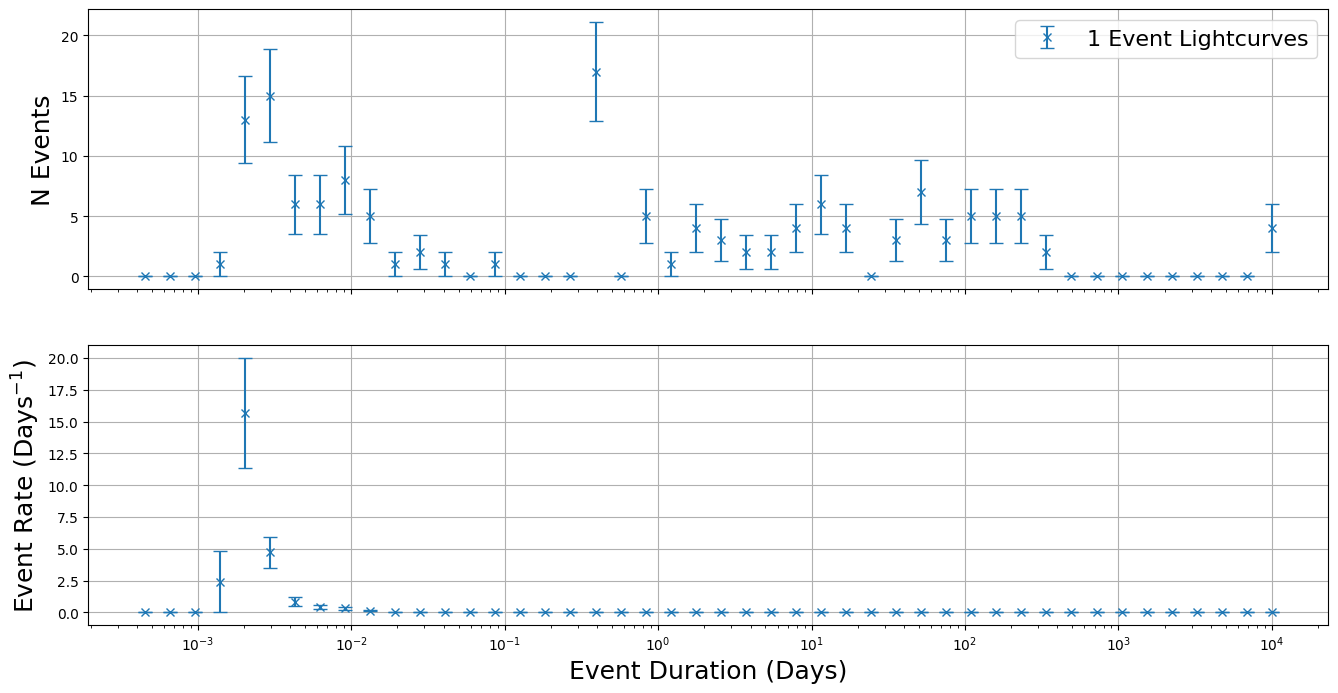

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
cmap = plt.get_cmap("gist_rainbow")
n = len(cadence_results_achromatic_factor.keys())
norm = Normalize(vmin=0, vmax=n-1)
colors = [cmap(norm(i)) for i in range(n)]
k = "1"
v = cadence_results_achromatic_factor[k]
c = colors[0]

# for (k, v), c in zip(cadence_results_achromatic_factor.items(), colors):
m = v[0] > 0
event_rate = v[1][m] / v[0][m]
err = np.sqrt(v[1][m]) / v[0][m]
axes[0].errorbar(taus[m], v[1][m], yerr=np.sqrt(v[1][m]), capsize=5, marker='x', label=f"{k} Event Lightcurves", ls="None")
axes[1].errorbar(taus[m], event_rate, yerr=err, capsize=5, marker='x', ls="None")

for ax in axes:
    ax.set_xscale("log")
    ax.grid(visible=True)

axes[0].set_ylabel("N Events", fontsize=18)
axes[0].legend(fontsize=16)
axes[1].set_xlabel("Event Duration (Days)", fontsize=18)
axes[1].set_ylabel(r"Event Rate (Days$^{-1}$)", fontsize=18)
plt.show(fig)
plt.close(fig)

In [ ]:
d = pd.read_parquet(f"{results_dir}lightcurves_batch29.parquet")

In [38]:
cadence_results_achromatic_factor["1"][:, 8]

array([ 0.83017715, 13.        ])

In [ ]:
# noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.day).value
# time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
# fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
# cmap = plt.get_cmap("gist_rainbow")
# n = len(cadence_results_achromatic_factor.keys())
# norm = Normalize(vmin=0, vmax=n-1)
# colors = [cmap(norm(i)) for i in range(n)]

# y_operations = [lambda y0, y1: y0, lambda y0, y1: y1, lambda y0, y1: y1 / y0]
# y_err_operations = [lambda y0, y1: 0, lambda y0, y1: np.sqrt(y1), lambda y0, y1: np.sqrt(y1) / y0]
# y_labels = ["Time Lensable (Day)", "N Events", r"Event Rate (Days$^{-1}$)"]

# for i in range(len(axes)):
#     ax = axes[i]
#     ylabel = y_labels[i]

#     for (k, v), c in zip(cadence_results_achromatic_factor.items(), colors):
#         m = v[0] > 0
#         y = y_operations[i](v[0][m], v[1][m])
#         yerr = y_err_operations[i](v[0][m], v[1][m])
#         ax.errorbar(taus[m], y, yerr=yerr, capsize=5, marker='x', label=f"{k} Event Lightcurves", ls="None")

#     ax.set_xscale("log")
#     # ax.set_yscale("log")
#     ax.set_ylabel(ylabel, fontsize=10)
#     ax.grid(visible=True)
#     blended_transform = ax.get_xaxis_transform()
#     axis_transform = ax.transAxes
#     axis_transform_inverse = axis_transform.inverted()
    
#     for t, l in zip(noteable_times, time_labels):
#         ax.axvline(t, ls="--", color='k')
#         (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.75)))
#         ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

# axes[0].legend(fontsize=16)
# axes[2].set_xlabel("Event Duration (Days)", fontsize=18)
# plt.show(fig)
# plt.close(fig)

/tmp/ipykernel_134998/2300249597.py:4: RuntimeWarning: invalid value encountered in divide
  ax.bar(n_samples_x, n_bright_y / n_samples_y, width=1)


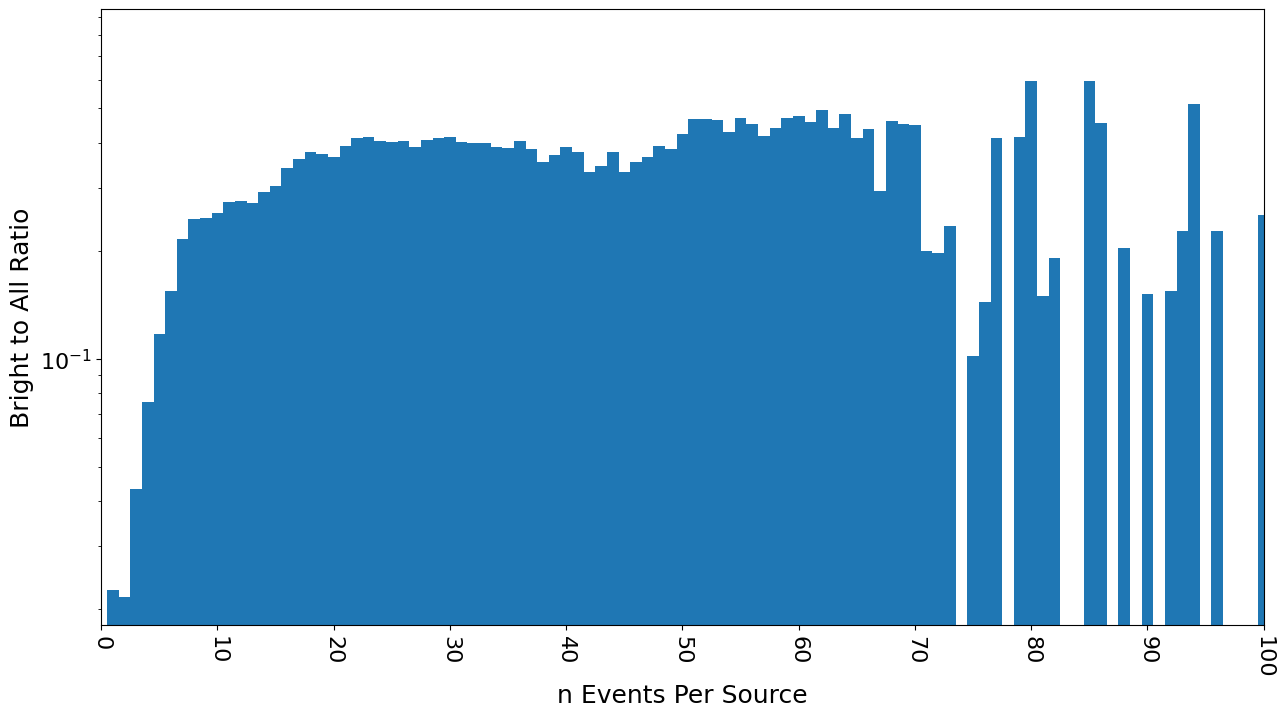

In [88]:
fig, ax = plt.subplots(figsize=(15, 8))
x_ticks = n_samples_x[::10]

ax.bar(n_samples_x, n_bright_y / n_samples_y, width=1)
# ax.plot(n_samples_x, normalizing_curve, color="tab:orange")
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=-90)
ax.set_xlim((x_ticks.min(), x_ticks.max()))
# ax.legend(loc="upper right", fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n Events Per Source", fontsize=18)
ax.set_ylabel("Bright to All Ratio", fontsize=18)
ax.tick_params(labelsize=16)
ax.set_xlim((0, 100))
# fig.savefig(f"{fig_dir}events_per_source_hist.png")
plt.show(fig)

In [115]:
(n_events_freq_df["all"] * n_events_freq_df["all"].index).sum() / n_events_freq_df["all"].sum()

13.199471840391999

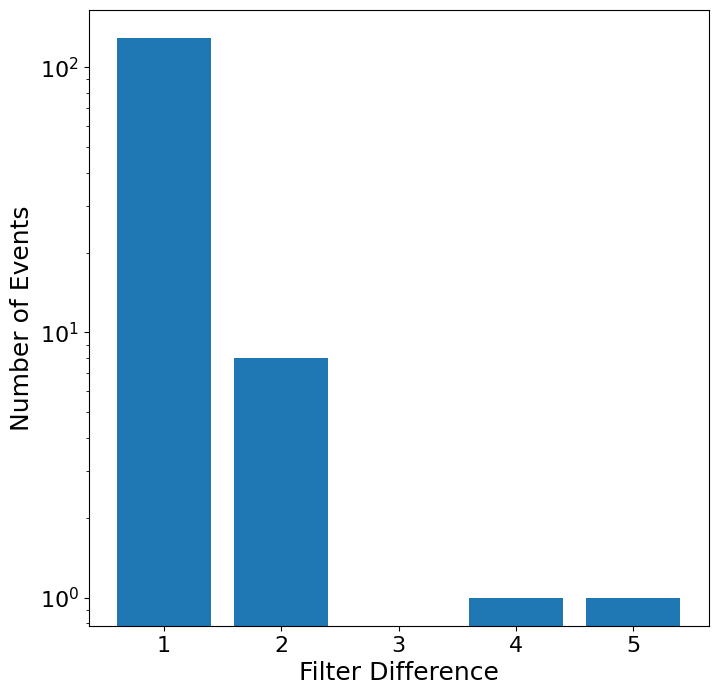

In [31]:
filter_diffs_hist = filter_diffs_achromatic_factor.value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(filter_diffs_hist.index, filter_diffs_hist)
ax.set_yscale("log")
ax.set_xlabel("Filter Difference", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}filter_difference_hist.png")
plt.show(fig)

In [51]:
filter_seq_count = results_df.groupby(by="filters").t_start.agg("count")

mask_two_sample_results = results_df["n_bright"] > 1
many_bright_ids = results_df.loc[results_df["n_bright"] > 9].index.get_level_values(0)

two_sample_ids = results_df.loc[mask_two_sample_results].index.get_level_values(0)
mask_two_sample = lc_df["objectid"].isin(two_sample_ids)

achromatic_ids = results_df.loc[results_df["achromatic"]].index.get_level_values(0)
mult2_ids = results_df.loc[results_df["multiplicity_2"]].index.get_level_values(0)
n_achromatic = len(achromatic_ids)

mask_achromatic = lc_df["objectid"].isin(achromatic_ids)
mask_bright = lc_df["cluster_label"] == 0
mask_mult2 = lc_df["objectid"].isin(mult2_ids)

bright_lc = lc_df.loc[mask_bright & mask_two_sample]
bright_achromatic_lc = lc_df.loc[mask_achromatic & mask_bright]
bright_achromatic_mult2_lc = lc_df.loc[mask_achromatic & mask_bright & mask_mult2]

flux_double = -2.5 * np.log10(2)

dmag_bins = np.linspace(-2.5, 0, num=26)
bright_achromatic = lc_df.loc[mask_achromatic & mask_bright]

mean_err = bright_achromatic["magerr_auto"].mean()
sigma_err = bright_achromatic["magerr_auto"].std()

achromatic_results = results_df.loc[results_df["achromatic"]]
achromatic_mult2_results = results_df.loc[results_df["achromatic"] & results_df["multiplicity_2"]]

n_distribution = results_df.loc[mask_two_sample_results].groupby(by="n_bright").filters.agg("count")
n_achromatic_distribution = achromatic_results.groupby(by="n_bright").filters.agg("count")
n_achromatic_mult2_distribution = achromatic_mult2_results.groupby(by="n_bright").filters.agg("count")

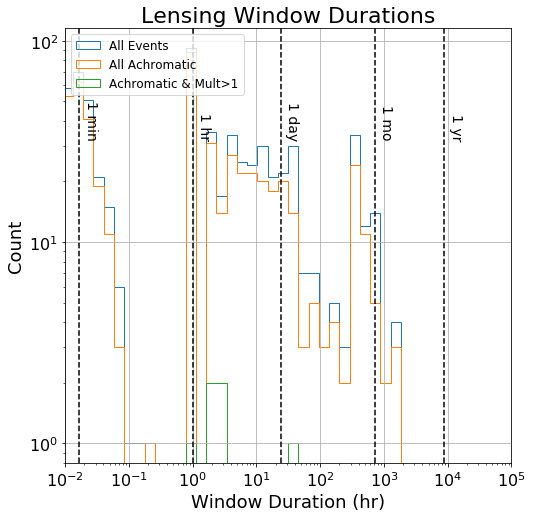

In [45]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.hr).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
finite_delta_t = np.isfinite(results_df["delta_t"].values)
bins = np.geomspace(results_df.loc[finite_delta_t, "delta_t"].min(), results_df.loc[finite_delta_t, "delta_t"].max() + 1, num=40)

fig, ax = plt.subplots(figsize=(8, 8))
results_df.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, ylabelsize=16, 
                label="All Events", histtype="step")

achromatic_results.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, 
                        ylabelsize=16, label="All Achromatic", histtype="step")

achromatic_mult2_results.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, 
                              ylabelsize=16,  label="Achromatic & Mult>1",  histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((1e-2, 1e5))
ax.legend(loc="upper left", fontsize=12)
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.75)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations.png")
plt.close(fig)

In [46]:
len(results_df), sum(results_df["achromatic"]), sum(results_df["multiplicity_2"])

(958, 806, 30)

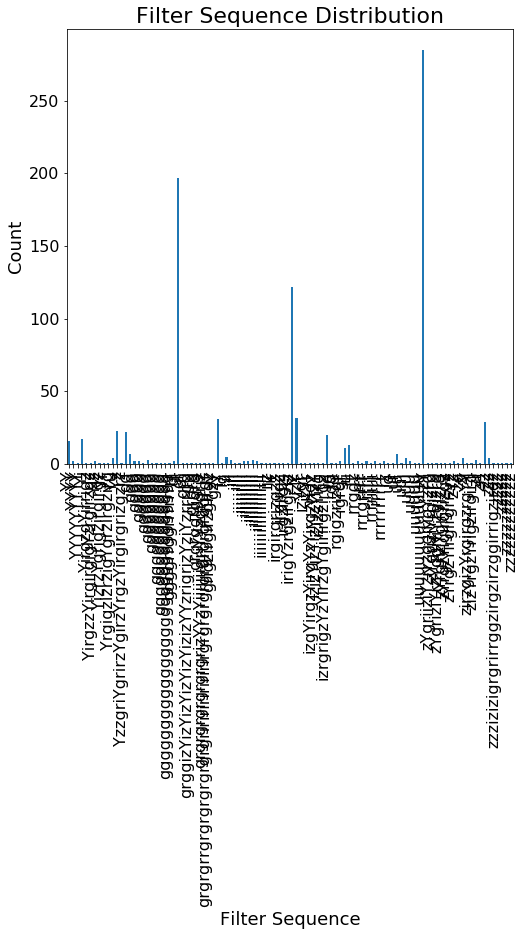

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
filter_seq_count.plot.bar(ax=ax)
ax.set_xlabel("Filter Sequence", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Filter Sequence Distribution", fontsize=22)
ax.tick_params(labelsize=16)
# ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha="right")
# ax.grid(visible=True)
plt.show(fig)
# fig.savefig(f"{fig_dir}filter_category_bar.png")
plt.close(fig)

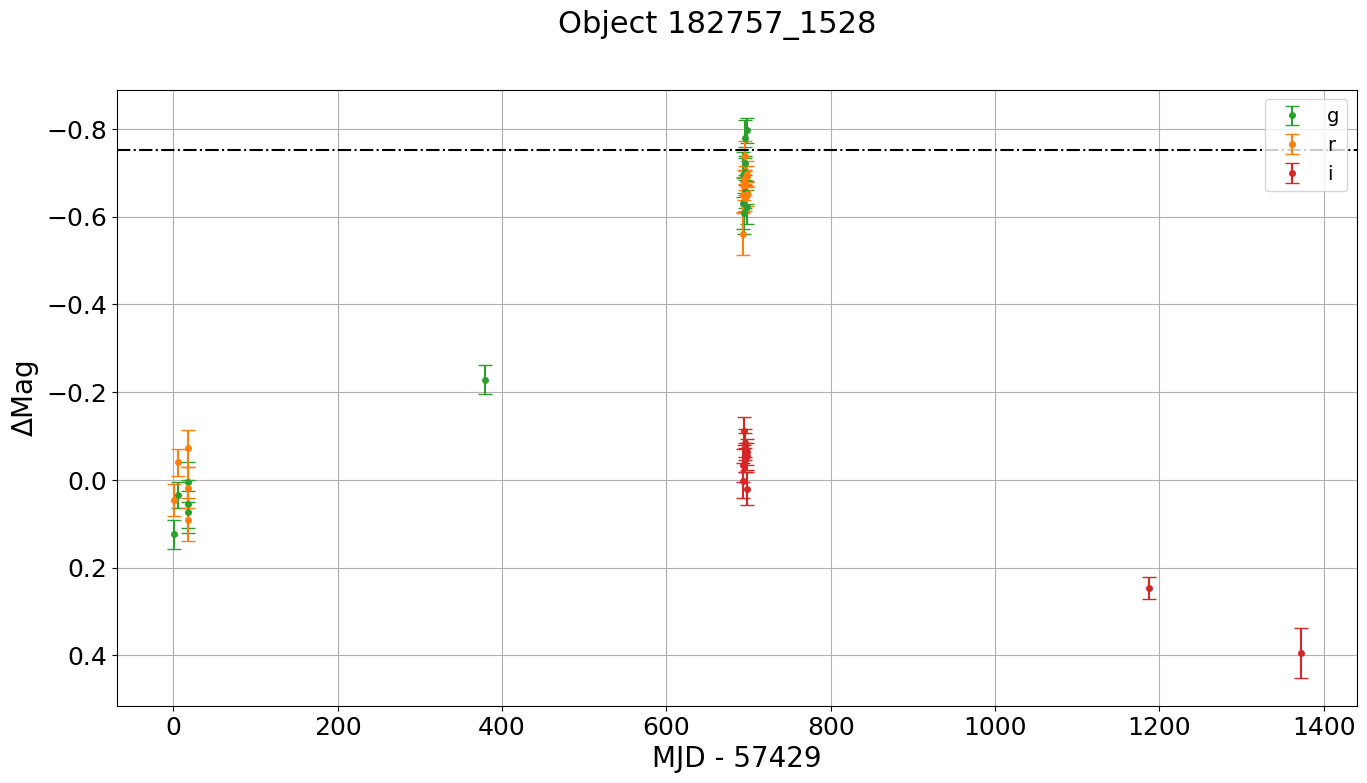

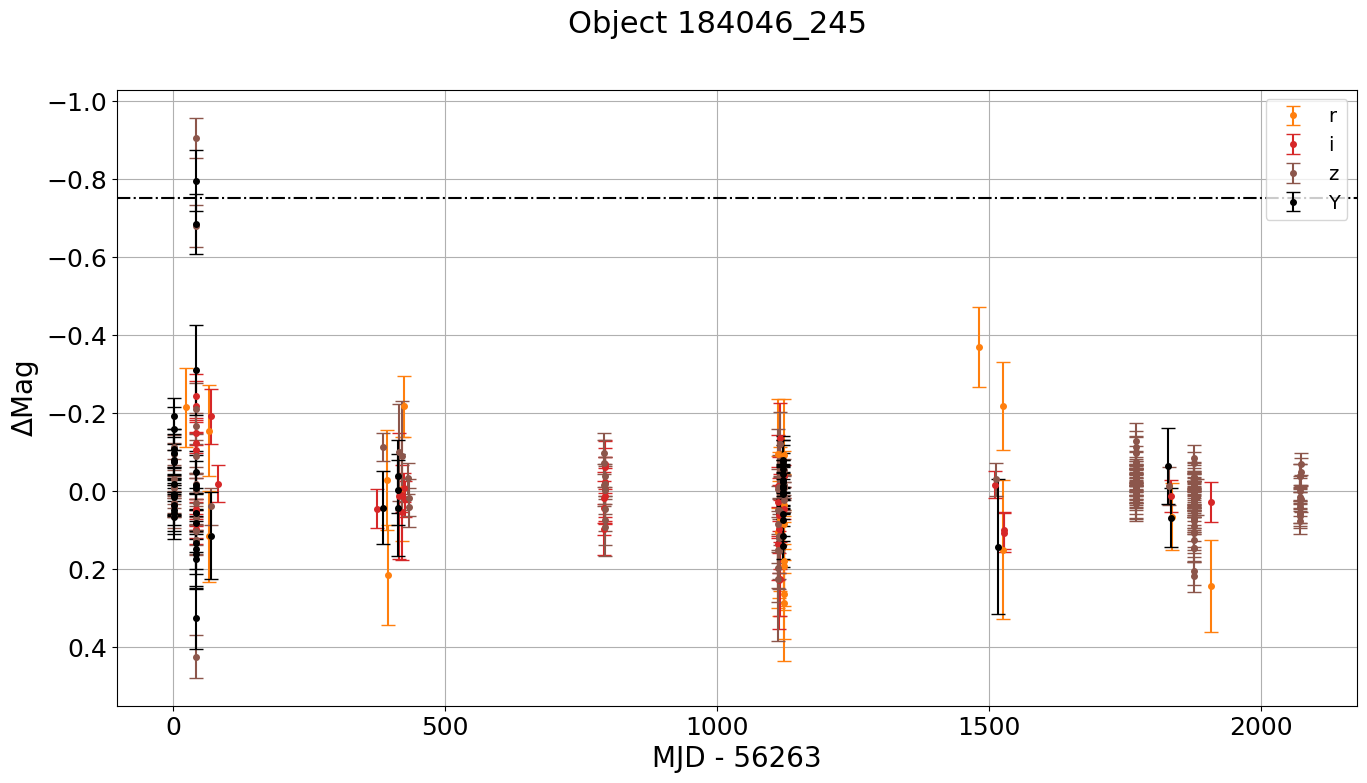

In [58]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", 'k'])
filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])
flux_double = -2.5 * np.log10(2)

plot_ids = n_events_per_source_achromatic_factor.loc[n_events_per_source_achromatic_factor > 1].index
# plot_ids = filter_diffs_achromatic_factor.loc[filter_diffs_achromatic_factor > 1].index.get_level_values(0)

for oid in plot_ids:
    m_id = lc_df_achromatic_factor["objectid"] == oid
    baseline_subtracted = datalab_utils.subtract_baseline(lc_df_achromatic_factor.loc[m_id])

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    min_mjd = int(baseline_subtracted["mjd"].min())
    
    for f, c in zip(filters, colors):
        m_f = baseline_subtracted["filter"] == f
        lc_full = baseline_subtracted.loc[m_f]
    
        if len(lc_full) > 0:
            ax.errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                        yerr=lc_full["magerr_auto"], marker='.', ms=8,
                        capsize=5, color=c, ls="None", label=f)
    
    ax.set_ylabel(r'$\Delta$Mag', fontsize=20)
    ax.tick_params(labelsize=18)
    ax.invert_yaxis()
    ax.grid(visible=True)
    ax.axhline(flux_double, color='k', linestyle="-.")
        
    ax.legend(fontsize=14, loc="upper right")
    ax.set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    fig.suptitle(f"Object {oid}", fontsize=22)
    plt.show(fig)
    # fig.savefig(f"{fig_dir}182757_1528_lightcurve_baseline_subtracted.png")
    plt.close(fig)

NameError: name 'results_df' is not defined

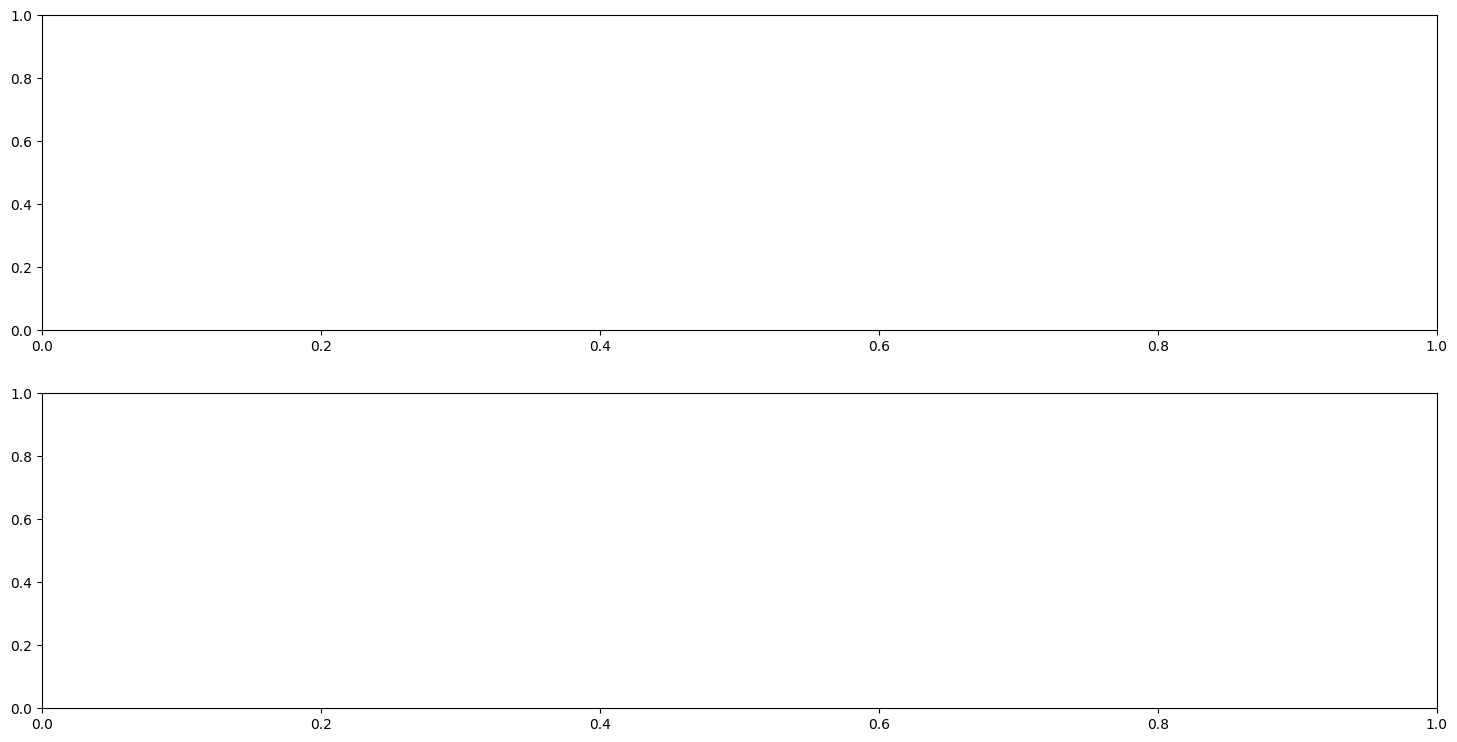

In [33]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", 'k'])
filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])

for oid in achromatic_ids[20:]:
    fig, axes = plt.subplots(2, 1, figsize=(18, 9))
    row = results_df.loc[(oid, 0)]
    ev_start, ev_end = row["t_start"], row["t_end"]
    m_id = lc_df["objectid"] == oid

    if ~np.isfinite(ev_start):
        ev_start = lc_df.loc[m_id, "mjd"].min()
    if ~np.isfinite(ev_end):
        ev_end = lc_df.loc[m_id, "mjd"].max()
    t_delta = ev_end - ev_start
    min_mjd = int(lc_df.loc[m_id, "mjd"].min())

    for f, c in zip(filters, colors):
        m_f = lc_df["filter"] == f
        lc_full = lc_df.loc[m_id & m_f]

        if len(lc_full) > 0:
            axes[0].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None", label=f)
            axes[1].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None")

    for ax in axes:
        ax.set_ylabel(r'$\Delta$Mag', fontsize=20)
        ax.tick_params(labelsize=18)
        ax.invert_yaxis()
        ax.grid(visible=True)
        barlims = (ev_start - min_mjd, ev_end - min_mjd)
        ax.axvspan(barlims[0], barlims[1], alpha=0.2, color="tab:gray")
        ax.axhline(flux_double, color='k', linestyle="-.")
        
    legend = axes[0].legend(fontsize=18, loc="upper right")
    axes[1].set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    t_lims = ((ev_start - 0.1 * t_delta) - min_mjd, (ev_end + 0.1 * t_delta) - min_mjd)
    axes[1].set_xlim(t_lims)
    fig.suptitle(f"Object {oid}", fontsize=22)
    plt.show(fig)
    fig.savefig(f"{fig_dir}{oid}_lightcurve_baseline_subtracted.png")
    plt.close(fig)

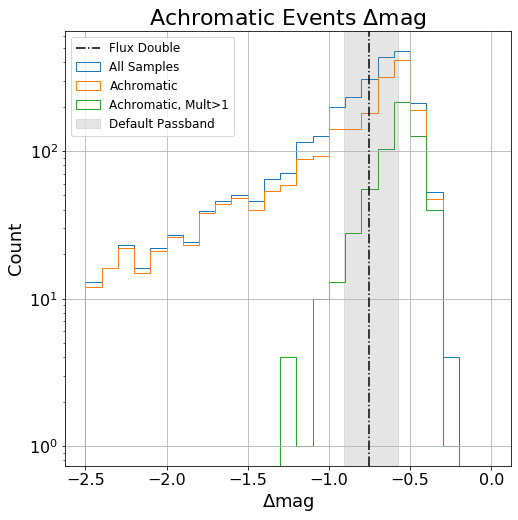

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))
bright_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="All Samples")
bright_achromatic_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="Achromatic")
bright_achromatic_mult2_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="Achromatic, Mult>1")
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.axvspan(-2.5 * np.log10(2.3), -2.5 * np.log10(1.7), alpha=0.2, 
           color="tab:gray", label="Default Passband")
ax.axvline(-2.5 * np.log10(2), color='k', ls="-.", label="Flux Double")
ax.set_yscale("log")
ax.tick_params(labelsize=16)
ax.legend(loc="upper left", fontsize=12)
ax.set_title(r"Achromatic Events $\Delta$mag", fontsize=22)
plt.show(fig)
# fig.savefig(f"{fig_dir}achromatic_events_deltamag.png")
plt.close(fig)

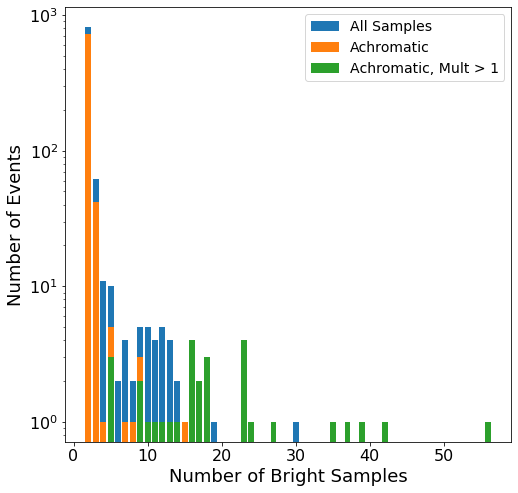

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(n_distribution.index, n_distribution, label="All Samples")
ax.bar(n_achromatic_distribution.index, n_achromatic_distribution, label="Achromatic")
ax.bar(n_achromatic_mult2_distribution.index, n_achromatic_mult2_distribution, label="Achromatic, Mult > 1")
ax.set_yscale("log")
ax.legend(loc="upper right", fontsize=14)
ax.set_xlabel("Number of Bright Samples", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=16)
plt.show(fig)

In [ ]:
# n_sources_per_n_events_all = np.full(n_samples_y_all.shape, np.nan)
# n_sources_per_n_events_all[n_events_freq_df["all"].index] = n_events_freq_df["all"]
# np.place(n_sources_per_n_events_all, n_sources_per_n_events_all < 1, np.nan)
# n_samples_per_source_all = n_samples_y_all / n_sources_per_n_events_all

# n_sources_per_n_events_achromatic = np.full(n_samples_y_achromatic.shape, np.nan)
# n_sources_per_n_events_achromatic[n_events_freq_df["achromatic"].index] = n_events_freq_df["achromatic"]
# np.place(n_sources_per_n_events_achromatic, n_sources_per_n_events_achromatic < 1, np.nan)
# n_samples_per_source_achromatic = n_samples_y_achromatic / n_sources_per_n_events_achromatic

# n_sources_per_n_events_achromatic_factor = np.full(n_samples_y_achromatic_factor.shape, np.nan)
# n_sources_per_n_events_achromatic_factor[n_events_freq_df["achromatic_factor2"].index] = n_events_freq_df["achromatic_factor2"]
# np.place(n_sources_per_n_events_achromatic_factor, n_sources_per_n_events_achromatic_factor < 1, np.nan)
# n_samples_per_source_achromatic_factor = n_samples_y_achromatic_factor / n_sources_per_n_events_achromatic_factor

# normalizing_curve_all = n_samples_per_source_all[50] * n_samples_x_all / 50

# fig, ax = plt.subplots(figsize=(15, 8))
# x_ticks = n_samples_x_all[::10]

# ax.bar(n_samples_x_all, n_samples_per_source_all, width=1, label="All")
# ax.bar(n_samples_x_achromatic, n_samples_per_source_achromatic, width=1, label="Achromatic")
# ax.bar(n_samples_x_achromatic_factor, n_samples_per_source_achromatic_factor, width=1, label="Achromatic Factor2")
# ax.plot(n_samples_x_all, normalizing_curve_all, color="k", label=f"y = {n_samples_per_source_all[50]:0.2f} * x")
# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_ticks, rotation=-90)
# ax.set_xlim((x_ticks.min(), x_ticks.max()))
# ax.legend(loc="upper left", fontsize=16)
# ax.set_yscale("log")
# ax.set_xlabel("n Events Per Source", fontsize=18)
# ax.set_ylabel("Mean Number of Samples Per Source", fontsize=18)
# ax.tick_params(labelsize=16)
# # ax.set_xlim((0, 100))
# fig.savefig(f"{fig_dir}samples_per_source_hist.png")
# plt.show(fig)